In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! mkdir ~/.kaggle #-,kaggle

In [3]:
! cp /content/drive/MyDrive/Colab\ Notebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/


In [4]:
! kaggle datasets download tanlikesmath/diabetic-retinopathy-resized

100% 7.25G/7.25G [06:31<00:00, 22.3MB/s]
100% 7.25G/7.25G [06:31<00:00, 19.9MB/s]


In [5]:
!unzip diabetic-retinopathy-resized.zip

Streaming output truncated to the last 5000 lines.
  inflating: resized_train_cropped/resized_train_cropped/44260_right.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44261_left.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44261_right.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44262_left.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44262_right.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44263_left.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44263_right.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44264_left.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44264_right.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44265_left.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44265_right.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44267_left.jpeg  
  inflating: resized_train_cropped/resized_

In [1]:
import io
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import tensorflow as tf
from keras.utils import normalize, to_categorical
import shutil

plt.style.use("ggplot")
%matplotlib inline

## Collect random sample from dataset

In [112]:
csv_file      = 'trainLabels.csv'
dataset_path = os.path.join('/content','resized_train','resized_train')

In [113]:
def collect_random_dataset(dataset_path,csv_file,num_sample):

    #csv_file_path = os.path.join('eye_dataset',csv_file)
    data = pd.read_csv(csv_file)

    value_list = data['level'].value_counts().index.tolist()

    index_value = []

    for value in value_list:
        data_value = data[data['level'] == value].index
        index_value.append(data_value)

    full_index = []

    for indices in index_value:
        data_list = random.sample(indices.tolist(), num_sample)
        full_index.extend(data_list)

    random_data = data.iloc[full_index]

    image_ = []
    level_ = []

    for ind,(image,level) in random_data.iterrows():
        image_path = os.path.join(dataset_path,f'{image}.jpeg')
        image_.append(image_path)
        level_.append(level)

    return image_,level_

In [114]:
image,level = collect_random_dataset(dataset_path,csv_file,num_sample=300)

## Preprocess

In [115]:
def convert_into_array(image,level):
    level = np.array(level,dtype=float)
    level = to_categorical(level,num_classes=5)
    #file = tf.squeeze(file,axis=0)
    return image,level

In [116]:
image_path,level = convert_into_array(image,level)

In [117]:
level.shape

(1500, 5)

In [118]:
def Normalization(image,level):

    image   = tf.image.resize(image,(224,224))
    mean_per_channel = tf.reduce_mean(image, axis=(0, 1))
    std_per_channel  = tf.math.reduce_std(image,axis=(0,1))

    epsilon = 1e-8
    std_per_channel = tf.maximum(std_per_channel, epsilon)

    # Normalize each channel by subtracting its respective channel mean from each pixel value
    normalized_rgb_image = image - mean_per_channel
    normalized_rgb_image = normalized_rgb_image/std_per_channel

    return normalized_rgb_image,level

In [119]:
def preprocess(image_path, level):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))  # Adjust dimensions
    image = image / 255.0  # Normalize pixel values

    nor_image,level = Normalization(image,level)
    return nor_image, level

In [120]:
data = tf.data.Dataset.from_tensor_slices((image_path, level))
data = data.shuffle(buffer_size=12452)
data = data.map(preprocess)
data = data.batch(16)
data = data.prefetch(tf.data.AUTOTUNE)

In [121]:
sample = data.as_numpy_iterator().next()

In [122]:
sample[0].shape

(16, 224, 224, 3)

In [123]:
sample[1].shape

(16, 5)

(<matplotlib.image.AxesImage at 0x78b432905bd0>,
 array([0., 0., 0., 1., 0.], dtype=float32))

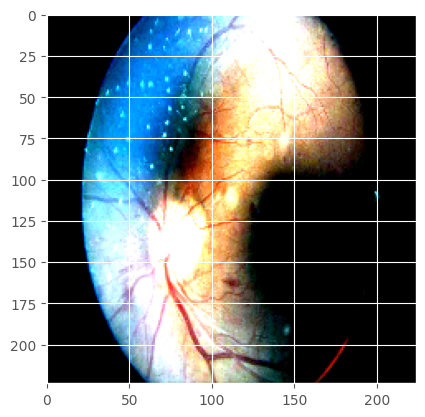

In [124]:
plt.imshow(sample[0][5]),sample[1][5]

In [125]:
94*0.7

65.8

In [126]:
train_data = data.take(65)
test_data = data.skip(65)

In [134]:
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate,Conv2D,Dense,Flatten
from tensorflow.keras.optimizers import Adam,Adadelta,RMSprop
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg16 import VGG16

In [128]:
wei = os.path.join('DL_model_weights','vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [150]:
early_stop    = EarlyStopping(monitor='val_loss',patience=25,verbose=1)
checkpoint_cb = ModelCheckpoint("model_checkpoint_re.h5",save_best_only=True)

In [160]:
base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))

# Customize the top layers
x = base_model.output
x = Flatten()(x)
x = Dense(16, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)  # Assuming 5 classes in your dataset

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = RMSprop(learning_rate=0.001, centered=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])


In [133]:
history = model.fit(train_data,validation_data=test_data,epochs=200,
                    callbacks=[early_stop,checkpoint_cb])

Epoch 1/200
65/65 [==============================] - 8s 52ms/step - loss: 1.9661 - accuracy: 0.2087 - auc: 0.5045 - val_loss: 7.9597 - val_accuracy: 0.2000 - val_auc: 0.5093
Epoch 2/200
65/65 [==============================] - 3s 47ms/step - loss: 1.7872 - accuracy: 0.2163 - auc: 0.5252 - val_loss: 1.7238 - val_accuracy: 0.1870 - val_auc: 0.5194
Epoch 3/200
65/65 [==============================] - 3s 47ms/step - loss: 1.7494 - accuracy: 0.2337 - auc: 0.5252 - val_loss: 1.6852 - val_accuracy: 0.2217 - val_auc: 0.5071
Epoch 4/200
65/65 [==============================] - 3s 48ms/step - loss: 1.7207 - accuracy: 0.2288 - auc: 0.5302 - val_loss: 1.8267 - val_accuracy: 0.2109 - val_auc: 0.5046
Epoch 5/200
65/65 [==============================] - 3s 47ms/step - loss: 1.7214 - accuracy: 0.1913 - auc: 0.5063 - val_loss: 1.7722 - val_accuracy: 0.2457 - val_auc: 0.5280
Epoch 6/200
65/65 [==============================] - 3s 47ms/step - loss: 1.7153 - accuracy: 0.1894 - auc: 0.4924 - val_loss: 1.71

In [135]:
early_stop    = EarlyStopping(monitor='val_loss',patience=25,verbose=1)
checkpoint_cb = ModelCheckpoint("model_checkpoint_400.h5",save_best_only=True)

In [137]:
def scheduler(epoch, lr):
    if epoch < 100:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [138]:
schedule_callback = LearningRateScheduler(scheduler)

In [139]:
history_1 = model.fit(train_data,validation_data=test_data,epochs=200,
                    callbacks=[early_stop,checkpoint_cb,schedule_callback])

Epoch 1/200
65/65 [==============================] - 3s 54ms/step - loss: 0.5990 - accuracy: 0.7500 - auc: 0.9530 - val_loss: 0.3712 - val_accuracy: 0.8761 - val_auc: 0.9879 - lr: 0.0010
Epoch 2/200
65/65 [==============================] - 4s 55ms/step - loss: 0.5654 - accuracy: 0.7731 - auc: 0.9590 - val_loss: 0.2497 - val_accuracy: 0.9370 - val_auc: 0.9954 - lr: 0.0010
Epoch 3/200
65/65 [==============================] - 3s 48ms/step - loss: 0.5582 - accuracy: 0.7788 - auc: 0.9595 - val_loss: 0.2574 - val_accuracy: 0.9522 - val_auc: 0.9969 - lr: 0.0010
Epoch 4/200
65/65 [==============================] - 3s 47ms/step - loss: 0.5909 - accuracy: 0.7606 - auc: 0.9551 - val_loss: 0.5522 - val_accuracy: 0.8500 - val_auc: 0.9730 - lr: 0.0010
Epoch 5/200
65/65 [==============================] - 3s 47ms/step - loss: 0.6552 - accuracy: 0.7635 - auc: 0.9463 - val_loss: 0.2802 - val_accuracy: 0.9391 - val_auc: 0.9955 - lr: 0.0010
Epoch 6/200
65/65 [==============================] - 4s 55ms/step

In [2]:
def plot_model_perfomance(model):
    history_post_training = model.history

    train_loss = history_post_training['loss']
    test_loss = history_post_training['val_loss']

    train_accuracy = history_post_training['accuracy']
    test_accuracy = history_post_training['val_accuracy']

    train_AUC = history_post_training['auc']
    test_AUC = history_post_training['val_auc']

    plt.figure(1)
    plt.plot(train_loss, 'b-')
    plt.plot(test_loss, 'r-')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.title('loss graph', fontsize=12)
    plt.legend(['train','test'])


    plt.figure(2)
    plt.plot(train_accuracy, 'b-')
    plt.plot(test_accuracy, 'r-')

    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    plt.title('Accuracy graph', fontsize=12)
    plt.legend(['train','test'])

    plt.figure(3)
    plt.plot(train_AUC, 'b-')
    plt.plot(test_AUC, 'r-')

    plt.xlabel('iterations')
    plt.ylabel('AUC')
    plt.title('AUC', fontsize=12)
    plt.legend(['train','test'])

    plt.show()

In [181]:
vgg = pd.DataFrame(history.history)

In [196]:
vgg_model = load_model('/content/model_checkpoint_400.h5')

In [202]:
pred = np.argmax(vgg_model.predict(sample[0]),axis=1)

1/1 [==============================] - 0s 30ms/step


In [203]:
true = np.argmax(sample[1],axis=1)

In [204]:
from sklearn.metrics import cohen_kappa_score

In [206]:
kappa = cohen_kappa_score(true, pred)

print("Cohen's Kappa Coefficient:", kappa)

Cohen's Kappa Coefficient: 1.0


(<matplotlib.image.AxesImage at 0x78b46c15cfd0>,
 array([0., 0., 0., 1., 0.], dtype=float32))

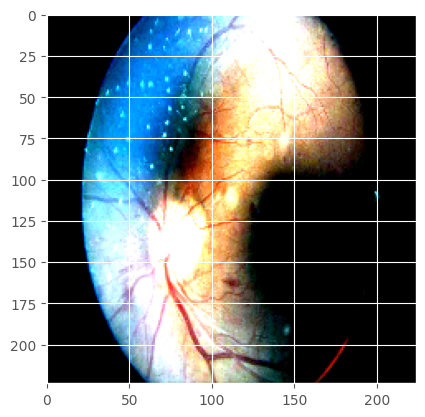

In [211]:
plt.imshow(sample[0][5]),sample[1][5]